# LiYS2

In [1]:
from mp_api.client import MPRester
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import minimize

In [2]:
mp_key = "PgRtTbiMJ5N3guKB8xgaTcXoz0bUQyKD"
mp_id = "mp-15788"

In [3]:
with MPRester(mp_key) as m:
    prim_struc = m.get_structure_by_material_id(mp_id)
    ph_dos = m.get_phonon_dos_by_material_id(mp_id)

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

# 1) Température de Debye

In [4]:
N_at = len(prim_struc)
R = 8.314

temp = np.array(np.arange(5, 1000, 5))
cv = np.array([ph_dos.cv(temp[i])/ (3*N_at*R) for i in range(len(temp))])

# Intégrale 
def fct(x):
    return (x**4*np.exp(x))/((np.exp(x)-1)**2)

def Debye(T, thetaD):
    return 3 * ((T/thetaD)**3) * quad(fct, 0, thetaD/T)[0]

def debye_error(thetaD):
    return np.sum([(Debye(temp[i], thetaD) - cv[i])**2 for i in range(len(temp))])

thetaD_init = 150
best_thetaD = minimize(debye_error, thetaD_init).x[0]
print("La température de Debye vaut ",best_thetaD, "K")

La température de Debye vaut  382.7527059058307 K


# 2) Température d'Einstein

In [5]:
def Einstein(T, thetaE):
    fract = thetaE/T
    return (fract**2) * (np.exp(fract)/(np.exp(fract)-1)**2)

def einstein_error(thetaE):
    cv_einstein = Einstein(temp, thetaE)
    return np.sum((cv-cv_einstein)**2)

thetaE_init = 150
best_thetaE = minimize(einstein_error, thetaE_init).x[0]
print("La température d'Einstein vaut ", best_thetaE, "K")

La température d'Einstein vaut  283.2087498806544 K


# 3) Courbes de chaleur spécifique

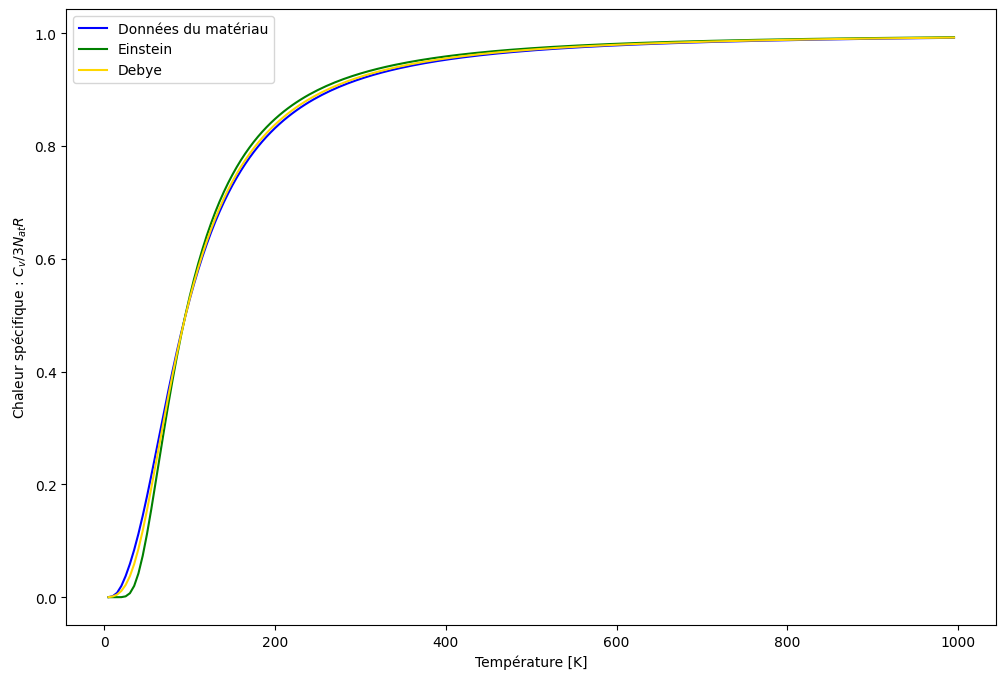

In [6]:
cv_debye = [Debye(T, best_thetaD) for T in temp]
cv_einstein = Einstein(temp, best_thetaE)

plt.figure(figsize=(12,8))
plt.plot(temp, cv, label='Données du matériau', color='blue')
plt.plot(temp, cv_einstein, label='Einstein', color='green')
plt.plot(temp, cv_debye, label='Debye', color='gold')
plt.xlabel('Température [K]')
plt.ylabel('Chaleur spécifique : $C_v/3N_{at}R$')
plt.legend()
plt.show()

# 4) Densité d'états de phonons

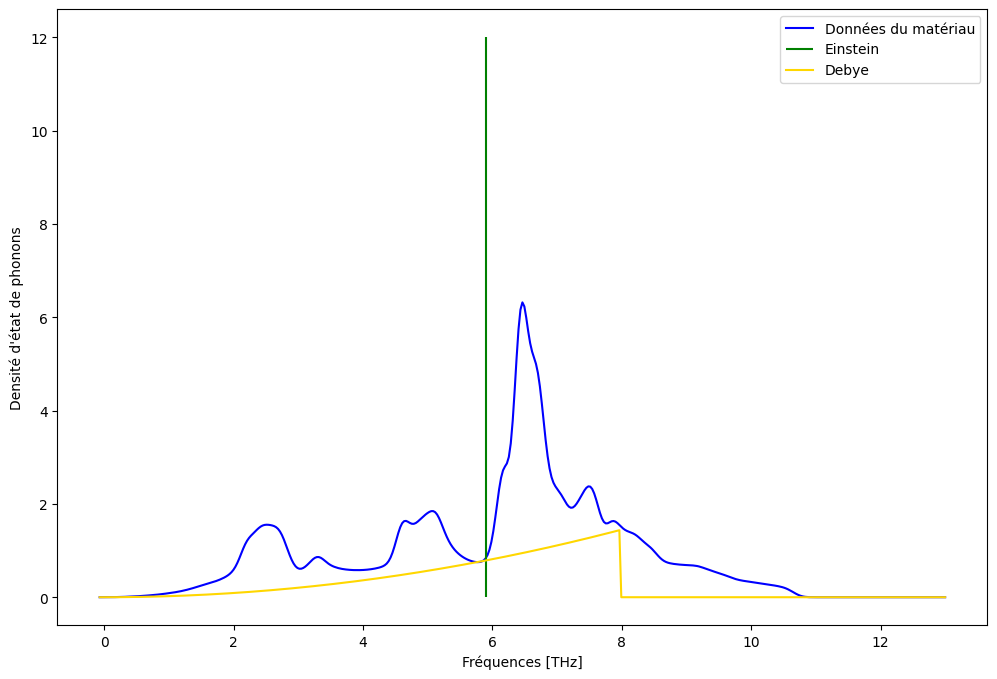

In [7]:
kb = 1.38e-23
hbar = 1.055e-34 

omega_debye = 1e-12*(kb*best_thetaD)/hbar 
omega_einstein = 1e-12*(kb*best_thetaE)/hbar

densité_debye = np.zeros(len(ph_dos.frequencies))
for i,f in enumerate(ph_dos.frequencies):
    omega = 2*np.pi*f
    if omega < omega_debye:
        densité_debye[i] = (9*N_at*(omega)**2)/(np.pi*(omega_debye**3))


plt.figure(figsize=(12,8))
plt.plot(ph_dos.frequencies, ph_dos.densities, color='blue', label='Données du matériau')
plt.vlines(omega_einstein/(2*np.pi), 0, 3*N_at, color='green', label='Einstein')
plt.plot(ph_dos.frequencies, densité_debye*2*np.pi, color='gold', label='Debye')
plt.xlabel('Fréquences [THz]')
plt.ylabel("Densité d'état de phonons")
plt.legend()
plt.show()